In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\prash\AppData\Local\Temp\ipykernel_19964\730530028.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
np.random.seed(1)
# training set
x1 =  np.random.uniform(6,size = 100) # x1 between [0,6]
x1 = np.around(x1, 2)
x2 =  np.random.uniform(6,size = 100) # x2 between [0,6]
x2 = np.around(x2, 2)
x3 =  np.random.uniform(-6, 0 ,size = 100) # x3 between [-6,0]
x3 = np.around(x3, 2)
x4 =  np.random.uniform(-6, 0, size = 100) # x4 between [-6,0]
x4 = np.around(x4, 2)

dataset_0_0 = pd.DataFrame({'x1': x1[ : 50], 'x2': x2[ : 50], 'y': [0]*50})
# dataset_0_0
dataset_0_1 = pd.DataFrame({'x1': x1[50 : ], 'x2': x4[ : 50], 'y': [1]*50})
# print(dataset_0_1)
dataset_1_0 = pd.DataFrame({'x1': x3[ : 50], 'x2': x2[50 : ], 'y': [1]*50})
# dataset_1_0
dataset_1_1 = pd.DataFrame({'x1': x3[50 : ], 'x2': x4[50 : ], 'y': [0]*50})
# dataset_1_1
train_data = pd.concat([dataset_0_0, dataset_0_1, dataset_1_0, dataset_1_1])
# randomly shuffled the train_data
# train_data = train_data.sample(frac = 1).reset_index(drop = True)
train_data

,x1,x2,y
0,3.91,4.37,0
1,2.40,3.36,0
2,6.00,1.57,0
3,4.49,4.21,0
4,5.27,1.46,0
...,...,...,...
45,-5.59,-0.94,0
46,-3.73,-3.71,0
47,-5.52,-1.50,0
48,-0.10,-2.93,0


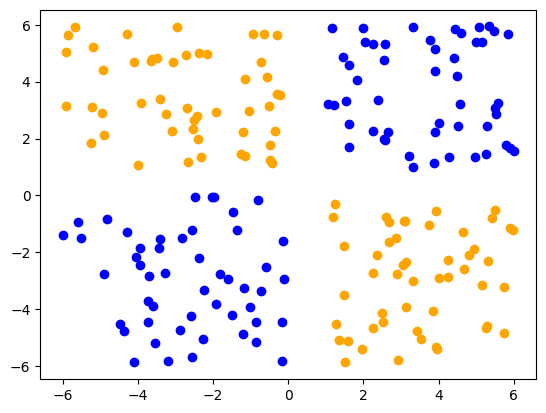

In [6]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(train_data['x1'][train_data['y'] == 0], train_data['x2'][train_data['y'] == 0], color = 'blue')
ax.scatter(train_data['x1'][train_data['y'] == 1], train_data['x2'][train_data['y'] == 1], color = 'orange')

In [7]:
np.random.seed(20)
# test set
x1 =  np.random.uniform(6,size = 100) # x1 between [0,6]
x1 = np.around(x1, 2)
x2 =  np.random.uniform(6,size = 100) # x2 between [0,6]
x2 = np.around(x2, 2)
x3 =  np.random.uniform(-6, 0 ,size = 100) # x3 between [-6,0]
x3 = np.around(x3, 2)
x4 =  np.random.uniform(-6, 0, size = 100) # x4 between [-6,0]
x4 = np.around(x4, 2)

dataset_0_0 = pd.DataFrame({'x1': x1[ : 50], 'x2': x2[ : 50], 'y1': [0]*50})
# dataset_0_0
dataset_0_1 = pd.DataFrame({'x1': x1[50 : ], 'x2': x4[ : 50], 'y1': [1]*50})
# dataset_0_1
dataset_1_0 = pd.DataFrame({'x1': x3[ : 50], 'x2': x2[50 : ], 'y1': [1]*50})
# dataset_1_0
dataset_1_1 = pd.DataFrame({'x1': x3[50 : ], 'x2': x4[50 : ], 'y1': [0]*50})
# dataset_1_1
test_data = pd.concat([dataset_0_0, dataset_0_1, dataset_1_0, dataset_1_1])
# randomly shuffled the test_data
# test_data = test_data.sample(frac= 1).reset_index(drop= True) 
# test_data

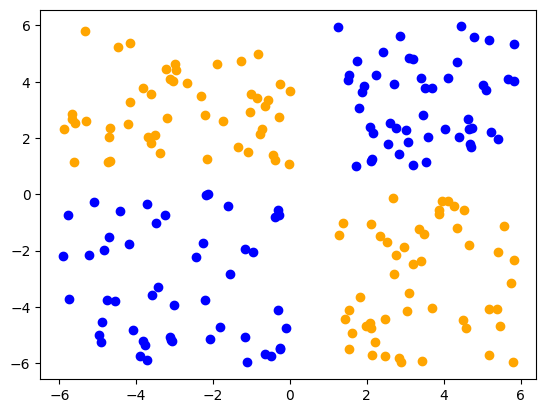

In [8]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(test_data['x1'][test_data['y1'] == 0], test_data['x2'][test_data['y1'] == 0], color = 'blue')
ax.scatter(test_data['x1'][test_data['y1'] == 1], test_data['x2'][test_data['y1'] == 1], color = 'orange')

In [9]:
# # Define the MLP model
# class MLP(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, 2)
#         self.fc3 = nn.Linear(2, 1)
#         self.sigmoid = nn.Sigmoid()
    


#     def forward(self, x):
#         out = self.fc1(x)
#         out = self.sigmoid(out)
#         out = self.fc2(out)
#         out = self.fc3(out)
#         out = self.sigmoid(out)
#         return out


# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    


    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [10]:
# Define custom dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [11]:
# Shuffle train and test data
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

# Define features and target variable
X_train = train_data[['x1', 'x2']].values.astype(np.float32)
y_train = train_data['y'].values.reshape(-1, 1).astype(np.float32)
X_test = test_data[['x1', 'x2']].values.astype(np.float32)
y_test = test_data['y1'].values.reshape(-1, 1).astype(np.float32)

# Create DataLoader
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=True)

In [12]:
# Initialize the model, loss function, and optimizer
model = MLP(input_size=2, hidden_size=4)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.03)
model

MLP(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [13]:
# baseline accuracy and loss
accuracy, train_loss = 0, 0
for inputs, labels in train_loader:
    outputs = model(inputs)
    output_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
    accuracy += torch.sum(output_labels == labels)
    loss = criterion(outputs, labels)
    train_loss += loss.item() 

print(f'Baseline accuracy {accuracy / len(train_loader.dataset)}, baseline loss {train_loss/len(train_loader)}')

Baseline accuracy 0.5799999833106995, baseline loss 0.7084290385246277


In [14]:
# Training loop
epochs = 1000
train_losses = []
for epoch in range(epochs):
    train_loss = 0.0
    accuracy = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        output_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
        accuracy += torch.sum(output_labels == labels)
        loss = criterion(outputs, labels)
        # print('Loss: ', loss)
        loss.backward()
        optimizer.step()
        # train_loss += loss.item() * inputs.size(0)
        train_loss += loss.item() 
    
    if epoch % 100 ==0:
        print(f'Epoch {epoch} Accuracy {accuracy/len(train_loader.dataset):.4f}')

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
# print(torch.hstack([inputs, outputs, output_labels, labels]))
total_train_loss = np.mean(train_losses)
print(f'Training loss: {total_train_loss:.4f}')

Epoch 0 Accuracy 0.5800
Epoch 100 Accuracy 0.8850
Epoch 200 Accuracy 0.8700
Epoch 300 Accuracy 0.8700
Epoch 400 Accuracy 0.8750
Epoch 500 Accuracy 0.8750
Epoch 600 Accuracy 0.8700
Epoch 700 Accuracy 0.8700
Epoch 800 Accuracy 0.8750
Epoch 900 Accuracy 0.8700
Training loss: 0.3113


In [15]:
test_loss = 0.0
accuracy = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        output_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
        # print(torch.hstack([inputs, outputs, output_labels, labels]))
        accuracy += torch.sum(output_labels == labels)
        loss = criterion(outputs, labels)
        # test_loss += loss.item() * inputs.size(0)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f'Test loss: {test_loss:.4f}, accuracy: {accuracy/len(test_loader.dataset):.4f}')

Test loss: 0.2896, accuracy: 0.8800


In [16]:
input = torch.tensor([0.23, -0.45])
output = model(input)
print(output)

tensor([0.0257], grad_fn=<SigmoidBackward0>)


In [19]:
xx = torch.tensor(torch.arange(-6.0,7.0), requires_grad = False)
yy = torch.tensor(torch.arange(-6.0, 7.0), requires_grad = False)
xx, yy = torch.meshgrid(xx, yy)
xx1 = xx.reshape(-1, 1)
yy1 = yy.reshape(-1, 1)
data = torch.hstack([xx1,yy1])
z = model(data)
z = torch.where(z > 0.5, 1, 0)
z = z.reshape(13,13)
# torch.hstack([xx, yy, z])

C:\Users\prash\AppData\Local\Temp\ipykernel_19964\4181658087.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx = torch.tensor(torch.arange(-6.0,7.0), requires_grad = False)
C:\Users\prash\AppData\Local\Temp\ipykernel_19964\4181658087.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yy = torch.tensor(torch.arange(-6.0, 7.0), requires_grad = False)


Decision surface of MLP 

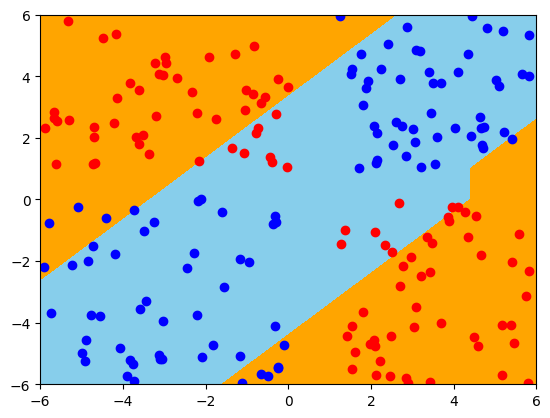

In [21]:
fig = plt.figure()
ax = plt.axes()
ax.contourf(xx, yy, z, colors = ['skyblue', 'orange', 'orange', 'skyblue'], levels = 2)
ax.scatter(test_data['x1'][test_data['y1']==0], test_data['x2'][test_data['y1']==0], color = 'blue')
ax.scatter(test_data['x1'][test_data['y1']==1], test_data['x2'][test_data['y1']==1], color = 'red')

MLP with L1 regularisation

In [22]:
# Define the MLP model
class MLP_L2(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP_L2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    


    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [23]:
# 5-fold cross validation
K = 5
epochs = 1000
block = len(train_data) // K
valid_loss_acc = {}

for learning_rate in [0.003,0.01, 0.03, 0.1, 0.3, 1]:
    for lagrange_multiplier in [0.001, 0.003, 0.01, 0.03, 0.1]:
        k_cross_val_loss = []
        k_cross_val_acc = []
        for i in range(K):
            start = i * block
            end = start + block
            val_dataset = train_data[start : end].reset_index(drop = True)
            X_val = val_dataset[['x1', 'x2']].values.astype(np.float32)
            y_val = val_dataset['y'].values.reshape(-1, 1).astype(np.float32)
            val_dataset = CustomDataset(X_val, y_val)
            val_loader = DataLoader(val_dataset, batch_size=40, shuffle=True)

            Xy_train = pd.concat([train_data[ : start], train_data[end : ]], axis = 0).reset_index(drop = True)
            X_train = Xy_train[['x1', 'x2']].values.astype(np.float32)
            y_train = Xy_train['y'].values.reshape(-1, 1).astype(np.float32)
            train_dataset = CustomDataset(X_train, y_train)
            train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
            
            # initialise MLP
            model = MLP_L2(input_size=2, hidden_size=4)
            criterion = nn.BCELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            # training the model
            train_losses = []
            for epoch in range(epochs):
                train_loss = 0.0
                accuracy = 0
                for inputs, labels in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    output_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
                    accuracy += torch.sum(output_labels == labels)
                    loss = criterion(outputs, labels)

                    sum = 0
                    for params in model.parameters():
                        params = params.view(-1)
                        sum += torch.sum(params)

                    loss += lagrange_multiplier * sum
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item() 
                
                if epoch % 100 == 0:
                    print(f'Epoch {epoch} Accuracy {accuracy/len(train_loader.dataset):.4f}')

                train_loss /= len(train_loader)
                train_losses.append(train_loss)
                
            # print(torch.hstack([inputs, outputs, output_labels, labels]))
            total_train_loss = np.mean(train_losses)
            print(f'In {i+1} Cross validation, Training loss: {total_train_loss:.4f}')


            # validate
            val_loss = 0.0
            accuracy = 0
            with torch.no_grad():
                for inputs, labels in val_loader:    
                    outputs = model(inputs)
                    output_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
                    # print(torch.hstack([inputs, outputs, output_labels, labels]))
                    accuracy += torch.sum(output_labels == labels)

                    loss = criterion(outputs, labels)
                    for params in model.parameters():
                        params = params.view(-1)
                        params = torch.square(params)
                        sum += torch.sum(params)
                    loss += lagrange_multiplier * sum

                    val_loss += loss.item()

            k_cross_val_loss.append(val_loss/len(val_loader))
            k_cross_val_acc.append(accuracy/len(val_dataset))
            print(f'Validation loss: {val_loss/len(val_loader):.4f}, Validation accuracy: {accuracy/len(val_dataset):.4f}')

        valid_loss_acc[f'{learning_rate}_{lagrange_multiplier}_loss'] = np.mean(k_cross_val_loss)
        valid_loss_acc[f'{learning_rate}_{lagrange_multiplier}_acc'] = np.mean(k_cross_val_acc)

Epoch 0 Accuracy 0.4938
Epoch 100 Accuracy 0.4750
Epoch 200 Accuracy 0.5562
Epoch 300 Accuracy 0.7250
Epoch 400 Accuracy 0.7937
Epoch 500 Accuracy 0.8438
Epoch 600 Accuracy 0.9000
Epoch 700 Accuracy 0.9125
Epoch 800 Accuracy 0.9312
Epoch 900 Accuracy 0.9438
In 1 Cross validation, Training loss: 0.5288
Validation loss: 0.3850, Validation accuracy: 0.9500
Epoch 0 Accuracy 0.2875
Epoch 100 Accuracy 0.5063
Epoch 200 Accuracy 0.6500
Epoch 300 Accuracy 0.8188
Epoch 400 Accuracy 0.8750
Epoch 500 Accuracy 0.9125
Epoch 600 Accuracy 0.9250
Epoch 700 Accuracy 0.9250
Epoch 800 Accuracy 0.9312
Epoch 900 Accuracy 0.9438
In 2 Cross validation, Training loss: 0.4419
Validation loss: 0.3194, Validation accuracy: 0.9750
Epoch 0 Accuracy 0.4812
Epoch 100 Accuracy 0.6875
Epoch 200 Accuracy 0.7500
Epoch 300 Accuracy 0.8500
Epoch 400 Accuracy 0.9563
Epoch 500 Accuracy 0.9812
Epoch 600 Accuracy 0.9875
Epoch 700 Accuracy 0.9875
Epoch 800 Accuracy 0.9937
Epoch 900 Accuracy 0.9937
In 3 Cross validation, Trainin

In [24]:
t = pd.DataFrame(valid_loss_acc, index = ['val']).T
t['val'] = t['val'].apply(lambda x: round(x, 2))
t

,val
0.003_0.001_loss,0.35
0.003_0.001_acc,0.95
0.003_0.003_loss,0.58
0.003_0.003_acc,0.85
0.003_0.01_loss,1.21
0.003_0.01_acc,0.72
0.003_0.03_loss,2.96
0.003_0.03_acc,0.65
0.003_0.1_loss,8.35
0.003_0.1_acc,0.57


In [25]:
model = MLP_L2(input_size=2, hidden_size=4)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.03)
lagrange_multiplier = 0.001

# training the model
for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        sum = 0
        for params in model.parameters():
            params = params.view(-1)
            params = torch.square(params)
            sum += torch.sum(params)

        loss += lagrange_multiplier * sum
        loss.backward()
        optimizer.step()
        

In [26]:
X_test = test_data[['x1', 'x2']].values.astype(np.float32)
y_test = test_data['y1'].values.reshape(-1, 1).astype(np.float32)
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=True)

test_loss = 0.0
accuracy = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        output_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
        # print(torch.hstack([inputs, outputs, output_labels, labels]))
        accuracy += torch.sum(output_labels == labels)
        loss = criterion(outputs, labels)
        # test_loss += loss.item() * inputs.size(0)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f'Test loss: {test_loss:.4f}, accuracy: {accuracy/len(test_loader.dataset):.4f}')

Test loss: 0.1706, accuracy: 0.9650


C:\Users\prash\AppData\Local\Temp\ipykernel_19964\1642735607.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx1 = torch.tensor(torch.arange(-6.0,7.0), requires_grad = False)
C:\Users\prash\AppData\Local\Temp\ipykernel_19964\1642735607.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx2 = torch.tensor(torch.arange(-6.0, 7.0), requires_grad = False)


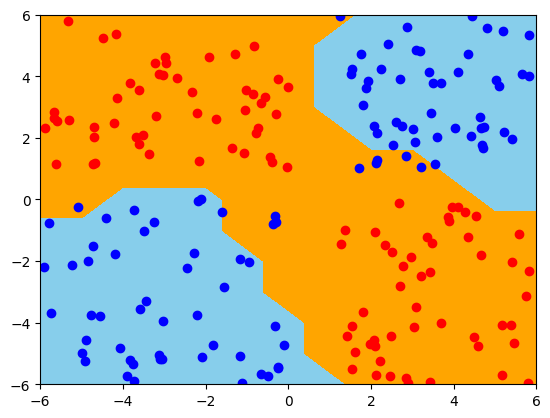

In [27]:
xx1 = torch.tensor(torch.arange(-6.0,7.0), requires_grad = False)
xx2 = torch.tensor(torch.arange(-6.0, 7.0), requires_grad = False)
xx1, xx2 = torch.meshgrid(xx1, xx2)
xx1 = xx1.reshape(-1, 1)
xx2 = xx2.reshape(-1, 1)
data = torch.hstack([xx1,xx2])
z = model(data)
z = torch.where(z > 0.5, 1, 0)
z = z.reshape(13,13)

fig = plt.figure()
ax = plt.axes()
ax.contourf(xx, yy, z, colors = ['skyblue', 'orange', 'orange', 'skyblue'], levels = 2)
ax.scatter(test_data['x1'][test_data['y1']==0], test_data['x2'][test_data['y1']==0], color = 'blue')
ax.scatter(test_data['x1'][test_data['y1']==1], test_data['x2'][test_data['y1']==1], color = 'red')

MLP with L2 Regularisation

In [28]:
# Define the MLP model
class MLP_L2(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP_L2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    


    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [29]:
# 5-fold cross validation
K = 5
epochs = 1000
block = len(train_data) // K
valid_loss_acc = {}

for learning_rate in [0.03]:
    for lagrange_multiplier in [0.001, 0.003, 0.01, 0.03, 0.1]:
        k_cross_val_loss = []
        k_cross_val_acc = []
        for i in range(K):
            start = i * block
            end = start + block
            val_dataset = train_data[start : end].reset_index(drop = True)
            X_val = val_dataset[['x1', 'x2']].values.astype(np.float32)
            y_val = val_dataset['y'].values.reshape(-1, 1).astype(np.float32)
            val_dataset = CustomDataset(X_val, y_val)
            val_loader = DataLoader(val_dataset, batch_size=40, shuffle=True)

            Xy_train = pd.concat([train_data[ : start], train_data[end : ]], axis = 0).reset_index(drop = True)
            X_train = Xy_train[['x1', 'x2']].values.astype(np.float32)
            y_train = Xy_train['y'].values.reshape(-1, 1).astype(np.float32)
            train_dataset = CustomDataset(X_train, y_train)
            train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
            
            # initialise MLP
            model = MLP_L2(input_size=2, hidden_size=4)
            criterion = nn.BCELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            # training the model
            train_losses = []
            for epoch in range(epochs):
                train_loss = 0.0
                accuracy = 0
                for inputs, labels in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    output_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
                    accuracy += torch.sum(output_labels == labels)
                    loss = criterion(outputs, labels)

                    sum = 0
                    for params in model.parameters():
                        params = params.view(-1)
                        params = torch.square(params)
                        sum += torch.sum(params)

                    loss += lagrange_multiplier * sum
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item() 
                
                if epoch % 20 == 0:
                    print(f'Epoch {epoch} Accuracy {accuracy/len(train_loader.dataset):.4f}')

                train_loss /= len(train_loader)
                train_losses.append(train_loss)
                
            # print(torch.hstack([inputs, outputs, output_labels, labels]))
            total_train_loss = np.mean(train_losses)
            print(f'In {i+1} Cross validation, Training loss: {total_train_loss:.4f}')


            # validate
            val_loss = 0.0
            accuracy = 0
            with torch.no_grad():
                for inputs, labels in val_loader:    
                    outputs = model(inputs)
                    output_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
                    # print(torch.hstack([inputs, outputs, output_labels, labels]))
                    accuracy += torch.sum(output_labels == labels)

                    loss = criterion(outputs, labels)
                    for params in model.parameters():
                        params = params.view(-1)
                        params = torch.square(params)
                        sum += torch.sum(params)
                    loss += lagrange_multiplier * sum

                    val_loss += loss.item()

            k_cross_val_loss.append(val_loss/len(val_loader))
            k_cross_val_acc.append(accuracy/len(val_dataset))
            print(f'Validation loss: {val_loss/len(val_loader):.4f}, Validation accuracy: {accuracy/len(val_dataset):.4f}')

        valid_loss_acc[f'{learning_rate}_{lagrange_multiplier}_loss'] = np.mean(k_cross_val_loss)
        valid_loss_acc[f'{learning_rate}_{lagrange_multiplier}_acc'] = np.mean(k_cross_val_acc)







Epoch 0 Accuracy 0.4938
Epoch 20 Accuracy 0.5188
Epoch 40 Accuracy 0.6938
Epoch 60 Accuracy 0.8313
Epoch 80 Accuracy 0.8938
Epoch 100 Accuracy 0.9375
Epoch 120 Accuracy 0.9438
Epoch 140 Accuracy 0.9625
Epoch 160 Accuracy 0.9688
Epoch 180 Accuracy 0.9688
Epoch 200 Accuracy 0.9688
Epoch 220 Accuracy 0.9688
Epoch 240 Accuracy 0.9688
Epoch 260 Accuracy 0.9688
Epoch 280 Accuracy 0.9688
Epoch 300 Accuracy 0.9688
Epoch 320 Accuracy 0.9688
Epoch 340 Accuracy 0.9688
Epoch 360 Accuracy 0.9688
Epoch 380 Accuracy 0.9688
Epoch 400 Accuracy 0.9688
Epoch 420 Accuracy 0.9688
Epoch 440 Accuracy 0.9688
Epoch 460 Accuracy 0.9688
Epoch 480 Accuracy 0.9688
Epoch 500 Accuracy 0.9688
Epoch 520 Accuracy 0.9688
Epoch 540 Accuracy 0.9688
Epoch 560 Accuracy 0.9688
Epoch 580 Accuracy 0.9688
Epoch 600 Accuracy 0.9688
Epoch 620 Accuracy 0.9688
Epoch 640 Accuracy 0.9688
Epoch 660 Accuracy 0.9688
Epoch 680 Accuracy 0.9688
Epoch 700 Accuracy 0.9688
Epoch 720 Accuracy 0.9688
Epoch 740 Accuracy 0.9688
Epoch 760 Accuracy

In [30]:
pd.DataFrame(valid_loss_acc, index = ['val']).T

,val
0.03_0.001_loss,0.463427
0.03_0.001_acc,0.920000
0.03_0.003_loss,0.642529
0.03_0.003_acc,0.935000
0.03_0.01_loss,0.744894
0.03_0.01_acc,0.605000
0.03_0.03_loss,0.699965
0.03_0.03_acc,0.430000
0.03_0.1_loss,0.698564
0.03_0.1_acc,0.430000


In [31]:
model = MLP_L2(input_size=2, hidden_size=4)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.03)
lagrange_multiplier = 0.001

# training the model
for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        sum = 0
        for params in model.parameters():
            params = params.view(-1)
            params = torch.square(params)
            sum += torch.sum(params)

        loss += lagrange_multiplier * sum
        loss.backward()
        optimizer.step()
        

In [32]:
X_test = test_data[['x1', 'x2']].values.astype(np.float32)
y_test = test_data['y1'].values.reshape(-1, 1).astype(np.float32)
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=True)

test_loss = 0.0
accuracy = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        output_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
        # print(torch.hstack([inputs, outputs, output_labels, labels]))
        accuracy += torch.sum(output_labels == labels)
        loss = criterion(outputs, labels)
        # test_loss += loss.item() * inputs.size(0)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f'Test loss: {test_loss:.4f}, accuracy: {accuracy/len(test_loader.dataset):.4f}')

Test loss: 0.1424, accuracy: 0.9900


C:\Users\prash\AppData\Local\Temp\ipykernel_19964\1642735607.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx1 = torch.tensor(torch.arange(-6.0,7.0), requires_grad = False)
C:\Users\prash\AppData\Local\Temp\ipykernel_19964\1642735607.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx2 = torch.tensor(torch.arange(-6.0, 7.0), requires_grad = False)


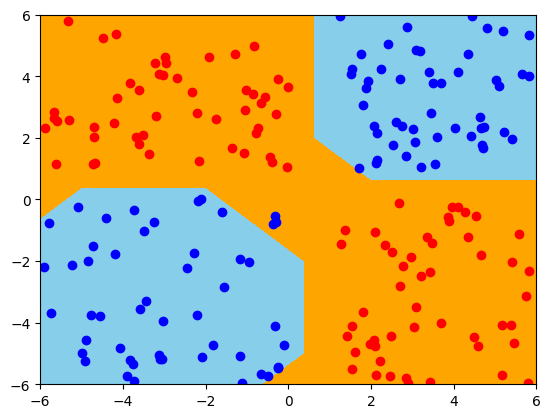

In [33]:
xx1 = torch.tensor(torch.arange(-6.0,7.0), requires_grad = False)
xx2 = torch.tensor(torch.arange(-6.0, 7.0), requires_grad = False)
xx1, xx2 = torch.meshgrid(xx1, xx2)
xx1 = xx1.reshape(-1, 1)
xx2 = xx2.reshape(-1, 1)
data = torch.hstack([xx1,xx2])
z = model(data)
z = torch.where(z > 0.5, 1, 0)
z = z.reshape(13,13)

fig = plt.figure()
ax = plt.axes()
ax.contourf(xx, yy, z, colors = ['skyblue', 'orange', 'orange', 'skyblue'], levels = 2)
ax.scatter(test_data['x1'][test_data['y1']==0], test_data['x2'][test_data['y1']==0], color = 'blue')
ax.scatter(test_data['x1'][test_data['y1']==1], test_data['x2'][test_data['y1']==1], color = 'red')

Logistic Regression Model

In [34]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        logits = self.linear(x)
        return logits

In [35]:
# Shuffle train and test data
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

In [45]:
X_train = pd.concat([train_data['x1'], train_data['x2'], train_data['x1']**2], axis = 1)
X_train.columns = ['x1','x2','x1^2']
X_train = torch.tensor(X_train.values, dtype= torch.float32)
y_train = train_data['y']
y_train = torch.tensor(y_train.values, dtype= torch.float32)
# y_train

In [46]:
reg = LogisticRegression(3)
opt = torch.optim.Adam(reg.parameters(), lr=0.01)
converged = False

prev_loss = 1e8

i = 0
while not converged:
    opt.zero_grad()
    logits = reg(X_train)
    logits = logits.reshape(-1)
    # print(logits)
    loss = F.binary_cross_entropy_with_logits(logits, y_train)
    loss.backward()
    opt.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item() 
    i = i + 1


pred = F.sigmoid(reg(X_train))
pred = torch.where(pred > 0.5 , 1.0, 0.0)
y_train = y_train.reshape(-1, 1)
correct_pred = torch.sum(pred == y_train)
acc = correct_pred / len(y_train)
print(f'Accurcay of Logistic regression using features x1, x2 and square of x1 is {acc}')

0 1.6326031684875488
10 1.1313185691833496
20 0.9154105186462402
30 0.8317301273345947
40 0.7447278499603271
50 0.7123233079910278
60 0.6986136436462402
70 0.694489598274231
80 0.6939997673034668
Accurcay of Logistic regression using features x1, x2 and square of x1 is 0.48500001430511475


In [47]:
X_train = pd.concat([train_data['x1'], train_data['x2'], train_data['x1']*train_data['x2']], axis = 1)
X_train.columns = ['x1','x2','x1x2']
X_train = torch.tensor(X_train.values, dtype= torch.float32)
y_train = train_data['y']
y_train = torch.tensor(y_train.values, dtype= torch.float32)

reg = LogisticRegression(3)
opt = torch.optim.Adam(reg.parameters(), lr=0.01)
converged = False

prev_loss = 1e8

i = 0
while not converged:
    opt.zero_grad()
    logits = reg(X_train)
    logits = logits.reshape(-1)
    loss = F.binary_cross_entropy_with_logits(logits, y_train)
    loss.backward()
    opt.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item() 
    i = i + 1

0 0.5990399718284607
10 0.3436237573623657
20 0.23454442620277405
30 0.1785074770450592
40 0.14528518915176392
50 0.12364727258682251
60 0.10850991308689117
70 0.0973244160413742
80 0.08870842307806015
90 0.08184996247291565
100 0.07624129951000214
110 0.07155061513185501
120 0.06755346059799194
130 0.06409314274787903
140 0.06105714663863182
150 0.05836287885904312
160 0.05594834312796593
170 0.053766269236803055
180 0.051779914647340775
190 0.04996032640337944
200 0.0482843741774559
210 0.04673329368233681
220 0.045291680842638016
230 0.04394683241844177
240 0.042688023298978806
250 0.04150622710585594
260 0.04039374738931656
270 0.03934396430850029
280 0.03835112601518631
290 0.037410229444503784
300 0.03651689365506172
310 0.03566725552082062
320 0.03485787287354469
330 0.034085702151060104
340 0.03334799408912659
350 0.032642316073179245
360 0.0319664366543293
370 0.03131835535168648
380 0.030696280300617218
390 0.03009854257106781
400 0.029523635283112526
410 0.02897016517817974


In [49]:
pred = F.sigmoid(reg(X_train))
pred = torch.where(pred > 0.5 , 1.0, 0.0)
y_train = y_train.reshape(-1, 1)
correct_pred = torch.sum(pred == y_train)
acc = correct_pred / len(y_train)
print(f'Training accuracy using Logistic Regression {acc}')

Training accuracy using Logistic Regression 1.0


In [50]:
X_test = pd.concat([test_data['x1'], test_data['x2'], test_data['x1']*test_data['x2']], axis = 1)
X_test.columns = ['x1','x2','x1x2']
X_test = torch.tensor(X_test.values, dtype= torch.float32)
y_test = test_data['y1']
y_test = torch.tensor(y_test.values, dtype= torch.float32)


pred = F.sigmoid(reg(X_test))
pred = torch.where(pred > 0.5 , 1.0, 0.0)
y_test = y_test.reshape(-1, 1)
correct_pred = torch.sum(pred == y_test)
acc = correct_pred / len(y_test)
print(f'Testing accuracy using Logistic Regression {acc}')

Testing accuracy using Logistic Regression 1.0


Decision surface of Logistic regression

C:\Users\prash\AppData\Local\Temp\ipykernel_19964\2707420995.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx1 = torch.tensor(torch.arange(-6.0,7.0), requires_grad = False)
C:\Users\prash\AppData\Local\Temp\ipykernel_19964\2707420995.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx2 = torch.tensor(torch.arange(-6.0, 7.0), requires_grad = False)


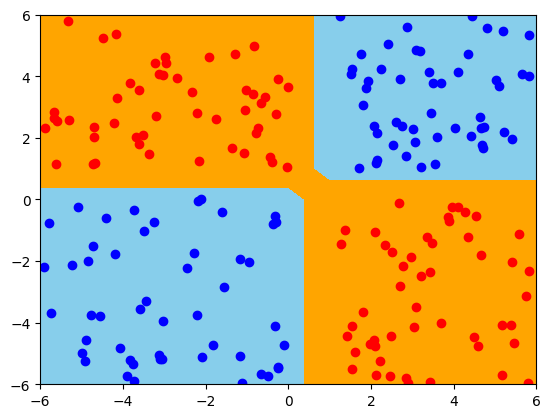

In [51]:
xx1 = torch.tensor(torch.arange(-6.0,7.0), requires_grad = False)
xx2 = torch.tensor(torch.arange(-6.0, 7.0), requires_grad = False)
xx1, xx2 = torch.meshgrid(xx1, xx2)
xx1 = xx1.reshape(-1, 1)
xx2 = xx2.reshape(-1, 1)
xx3 = xx1 * xx2
# print(xx3)
data = torch.hstack([xx1, xx2, xx3 ])
z = reg(data)
z = torch.where(z > 0.5, 1, 0)
z = z.reshape(13,13)

fig = plt.figure()
ax = plt.axes()
ax.contourf(xx, yy, z, colors = ['skyblue', 'orange', 'orange', 'skyblue'], levels = 2)
ax.scatter(test_data['x1'][test_data['y1']==0], test_data['x2'][test_data['y1']==0], color = 'blue')
ax.scatter(test_data['x1'][test_data['y1']==1], test_data['x2'][test_data['y1']==1], color = 'red')